In [2]:
from __future__ import division
import pickle
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import matplotlib.pyplot as plt
import pyLDAvis.gensim
import gensim.corpora

import gensim.models.ldamodel as ldamodel
%matplotlib inline
pyLDAvis.enable_notebook()

In [3]:
d = pickle.load(open('data/comments_data_processed_games.p','rb'))
comments = d['comments']
sentiments = d['sentiments']
comments_with_sentiments = pd.merge(comments,sentiments,on=['project_id','comment_id'],how='inner')
comments_with_sentiments.head(1)

# load stop words
stop_words_from_web = pickle.load(open('stop_words_from_web.p','rb'))['stop_words']
stop_words_list = [x for x in stop_words_from_web]
[stop_words_list.remove(x) for x in ['0', 'not','after', 'afterwards',  'again', 'later', 'love', 'none', 'unless', 'unlike', 'until', 'only', 'neither', 'against','unlikely','asked','everyone','everything','good'] if x in stop_words_list]
stop_words_list = stop_words_list + ['.','<','>','?','!',',']
stop_words_list = stop_words_list + ['$','(',')',"'","n't","'ll",":","-",";","'d","'ve","'re","...", "''", "``"]

## Remove high idf words

In [6]:
# group all comments by project
comments_processed = comments_with_sentiments.copy(deep=True)
g = comments_processed.groupby('project_id')

df_comments_processed_combined = None
count = 0
for proj_key, df_val in g:
    # concatentate all comments together
    combined_comment = ' '.join(df_val['comment'].values) 
    combined_comment = combined_comment.lower()
    
    # remove punctuation
    
    df0 = pd.DataFrame({'project_id':proj_key, 'all_text':combined_comment}, index=[count])
    count = count + 1
    if df_comments_processed_combined is None:
        df_comments_processed_combined = df0
    else:
        df_comments_processed_combined = pd.concat([df_comments_processed_combined, df0])

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopwords.words('english'), analyzer='word');
tfidf.fit(df_comments_processed_combined['all_text'].values);              

In [8]:
df_tfidf = pd.DataFrame(tfidf.vocabulary_.keys(),tfidf.vocabulary_.values())
df_tfidf['idf'] = tfidf.idf_[tfidf.vocabulary_.values()] # ordered by keys in vocabulary dictionary
df_tfidf.sort(columns='idf',ascending=False,inplace=True) # highest idf = lowest doc frequency

idf_cutoff = 7
df_tfidf_non_specific = df_tfidf[df_tfidf['idf'] < idf_cutoff]
stop_words_idf = df_tfidf[df_tfidf['idf'] > idf_cutoff][0].values

stop_words_full = stop_words_list + list(stop_words_idf)

## Separate comments from backers and creators

In [9]:
comments_with_sentiments.head(2)

,project_id,comment_id,comment,date,user,sentiment,word_count
0,1842798593,0,What an awesome tool and you are just the pers...,2013-11-15,James E. Vivian (deleted),1,42
1,1842798593,1,"Awesome to see your past your goal, good luck ...",2013-11-07,Tony Olsson,1,14


In [18]:
def get_commentor(row):
    if 'Creator' in row['user']:
        return 'creator'
    else:
        return 'backer'
comments_with_sentiments_user = comments_with_sentiments.copy(deep=True)
comments_with_sentiments_user['commentor_type'] = comments_with_sentiments_user.apply(get_commentor,axis=1)

In [162]:
df_creator = comments_with_sentiments_user[comments_with_sentiments_user['commentor_type']=='creator'].copy(deep=True)
df_backer = comments_with_sentiments_user[comments_with_sentiments_user['commentor_type']=='backer'].copy(deep=True)

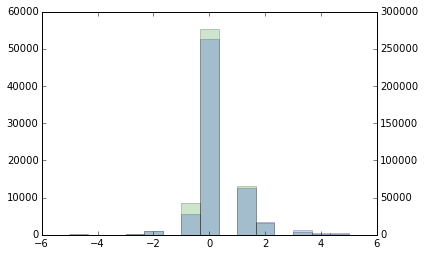

In [56]:
def window(x):
    if x < -5:
        return -5
    if x > 5:
        return 5
    else:
        return x
ax1 = plt.gca()
ax1.hist(map(window, df_creator['sentiment'].values),bins=15,alpha=0.2);
ax2 = ax1.twinx()
ax2.hist(map(window, df_backer['sentiment'].values),bins=15, alpha=0.2, color='g');

## Pool into 3-month intervals

In [244]:
def pool_comments(df0):
    
    df = df0.copy(deep=True)
    grouper = pd.TimeGrouper("1M")
    comments_grouped = None
    grouped_proj = df.groupby('project_id')

    count = 0
    for proj_key, df_val in grouped_proj:
        
#        return df_val
        # for each project, group into time periods and combine comments
     #       df_val.reset_index(inplace=True)
        df_val_grouped = df_val.set_index('date').groupby(grouper) # group into chunks
        
        for key, val in df_val_grouped:
            
            if val.shape[0] == 0:
                # do nothing
                x=3
            else:
                combined_comment = ' '.join(val['comment'].values)
                combined_comment = combined_comment.lower()

                # read into full dataframe
                df0 = pd.DataFrame({'project_id':proj_key, 'date':key, 'comment':combined_comment},index=[count])
                count = count + 1
                if comments_grouped is None:
                    comments_grouped = df0
                else:
                    comments_grouped = pd.concat([comments_grouped, df0])
    return comments_grouped

In [245]:
creator_comments_grouped = pool_comments(df_creator)
backer_comments_grouped = pool_comments(df_backer)

## Tokenize, remove stop words

In [246]:
def process_text(df, stop_words):
    # tokenize text (assumed lower case)
    tokenized = df.copy(deep=True)
    tokenized['tokenized'] = tokenized['comment'].apply(word_tokenize)
    
    # remove stop words
    stop_words_set = set(stop_words)
    stopped = tokenized.copy(deep=True)
    #stopped['stopped'] = stopped['tokenized'].apply(lambda x: list(set(x) - stop_words_set))
    stopped['stopped'] = stopped['tokenized'].apply(lambda X: [x for x in X if x not in stop_words_set])
    return stopped
    
def run_lda(df, num_topics=30): # dataframe with stop words removed
    texts = df['stopped'].values # list of split, lowered, tokenized words with stop words removed, NOT STEMMED
    dictionary = gensim.corpora.Dictionary(texts)

    id2word = {}
    for word in dictionary.token2id:    
        id2word[dictionary.token2id[word]] = word
    
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    lda = ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=id2word, passes=10, iterations=200)
    return lda, corpus, dictionary, id2word

In [247]:
creator_processed = process_text(creator_comments_grouped, stop_words_full)
backer_processed = process_text(backer_comments_grouped, stop_words_full)

In [248]:
n_topics = 30
lda_creator, corpus_creator, dictionary_creator, id2word_creator = run_lda(creator_processed,n_topics)
lda_backer, corpus_backer, dictionary_backer, id2word_backer = run_lda(backer_processed, n_topics)

In [256]:
lda_dir = 'lda_grouped_v2/'
lda_backer.save(lda_dir + 'lda_backer')
lda_creator.save(lda_dir + 'lda_creator')

In [472]:
to_save_creator = {'corpus':corpus_creator,'dictionary':dictionary_creator,'id2word':id2word_creator,'n_topics':n_topics,'stop_words':stop_words_full, 'comments':creator_processed}
to_save_backer = {'corpus':corpus_backer,'dictionary':dictionary_backer,'id2word':id2word_backer,'n_topics':n_topics,'stop_words':stop_words_full, 'comments':backer_processed}

pickle.dump(to_save_creator, open(lda_dir + 'data_creator.p', 'wb'))
pickle.dump(to_save_backer, open(lda_dir + 'data_backer.p', 'wb'))

In [249]:
pyLDAvis.gensim.prepare(lda_backer, corpus_backer, dictionary_backer)

/Users/alexmccauley/anaconda/lib/python2.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:107: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.00266993409582 and the largest is 0.552177403668.
  RuntimeWarning


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
15     11.430932        1       1 -0.081160  0.122467
23     10.615510        1       2 -0.105083  0.132429
26      7.769357        1       3 -0.110557  0.006408
27      7.120491        1       4 -0.102515  0.127479
10      6.126473        1       5 -0.080184  0.122173
22      6.029028        1       6 -0.100759 -0.060882
25      5.054267        1       7 -0.072747 -0.010511
1       4.879517        1       8 -0.090121  0.004903
0       4.495389        1       9 -0.080281 -0.106196
28      4.476253        1      10 -0.088079 -0.105286
2       4.298606        1      11 -0.099142  0.030746
14      4.014536        1      12 -0.100032 -0.068533
12      3.599166        1      13 -0.104228 -0.035107
21      3.272171        1      14 -0.090855 -0.147417
16      2.785035        1      15 -0.092709 -0.018024
5       2.676085        1      16 -0.071604  0.008001
18      2.614353        1      17 -0.098250 -0.068699
4       2.127691        1      18 -0.079459  0.077160
29      1.197839        1      19 -0.006050  0.090883
13      1.065827        1      20 -0.031159 -0.148081
17      1.037921        1      21  0.130303  0.222546
20      1.015934        1      22 -0.006147  0.106179
3       0.700899        1      23  0.086974 -0.218535
8       0.353476        1      24  0.059914  0.021626
11      0.302113        1      25  0.161943 -0.082489
24      0.270659        1      26  0.205805  0.019772
9       0.227010        1      27  0.234676 -0.033433
7       0.178874        1      28  0.269159 -0.042798
6       0.176831        1      29  0.155795  0.026088
19      0.087756        1      30  0.386553  0.027131, topic_info=      Category           Freq         Term   Total  loglift  logprob
101    Default   27881.000000           --   27881  30.0000  30.0000
91     Default   34264.000000       update   34264  29.0000  29.0000
42     Default  111724.000000            @  111724  28.0000  28.0000
31     Default   39442.000000       thanks   39442  27.0000  27.0000
343    Default   28590.000000     shipping   28590  26.0000  26.0000
270    Default   33019.000000  kickstarter   33019  25.0000  25.0000
403    Default   22932.000000     received   22932  24.0000  24.0000
445    Default   14010.000000      updates   14010  23.0000  23.0000
835    Default   13478.000000      printer   13478  22.0000  22.0000
451    Default   18184.000000          app   18184  21.0000  21.0000
28     Default   41907.000000      project   41907  20.0000  20.0000
339    Default    9726.000000         sent    9726  19.0000  19.0000
425    Default   10120.000000            &   10120  18.0000  18.0000
1094   Default   12372.000000       refund   12372  17.0000  17.0000
632    Default    9594.000000        power    9594  16.0000  16.0000
257    Default   16521.000000           hi   16521  15.0000  15.0000
306    Default   26895.000000       please   26895  14.0000  14.0000
24     Default  121117.000000          not  121117  13.0000  13.0000
469    Default    6562.000000       iphone    6562  12.0000  12.0000
816    Default   21757.000000         guys   21757  11.0000  11.0000
198    Default    9677.000000      comment    9677  10.0000  10.0000
99     Default   94687.000000           's   94687   9.0000   9.0000
410    Default   29764.000000          use   29764   8.0000   8.0000
747    Default   29322.000000      product   29322   7.0000   7.0000
19     Default    8073.000000        light    8073   6.0000   6.0000
47     Default    6691.000000        board    6691   5.0000   5.0000
14573  Default    7063.000000         pono    7063   4.0000   4.0000
307    Default   21799.000000       pledge   21799   3.0000   3.0000
521    Default   13441.000000       device   13441   2.0000   2.0000
381    Default   27551.000000         work   27551   1.0000   1.0000
...        ...            ...          ...     ...      ...      ...
19678  Topic30      1

In [522]:
lda_backer.show_topic(23,10)

[(0.029703293611544744, u'not'),
 (0.02223215169233789, u'project'),
 (0.015882263091839648, u'backers'),
 (0.015752197384213896, u'kickstarter'),
 (0.015027050627448699, u'product'),
 (0.012408357589130661, u'refund'),
 (0.011931668347799611, u"'s"),
 (0.011701282288494782, u'money'),
 (0.0084139429872144636, u'update'),
 (0.0077663708565615967, u'people')]

In [523]:
word_to_index['refund']

1094

In [389]:
from collections import defaultdict

In [423]:
# build word:index dictionary, and topic by word_proportion matrix
topic_list = range(n_topics)
word_to_index = defaultdict(dict)

n_rows = len(dictionary_backer)
n_cols = n_topics
topic_df = pd.DataFrame(data=np.zeros([n_rows, n_cols]),columns=range(n_cols))

for key in dictionary_backer:
    word = dictionary_backer[key]
    word_to_index[word] = key

for col in topic_list:    
    for x in lda_backer.show_topic(col, len(dictionary_backer)):    
        word = x[1]
        row = word_to_index[word]
        val = x[0]
        topic_df.loc[row][col] = val # topic_df contains P(word|topic)

In [459]:
pickle.dump(topic_df, open('lda_grouped_v2/topic_df_backer.p','wb'))

## More text processing, with bigrams

In [537]:
onecorp = backer_comments_grouped['comment'].values

In [540]:
wnl = nltk.stem.WordNetLemmatizer()
import re

def lowertitle(word):
        if word.istitle():
            word = word.lower()
        return word

def doc_lower_title(doc):
    return " ".join([lowertitle(word) for word in doc.split()])

def corpus_lower_title(corpus):
    return [doc_lower_title(doc) for doc in corpus]

def lemmatize_doc(doc):
    return " ".join([wnl.lemmatize(i) for i in nltk.word_tokenize(doc)])

def lemmatize_corpus(prepared_corpus):
    lem_corpus = []
    for doc in prepared_corpus:
        lem_corpus.append(lemmatize_doc(doc))
    return lem_corpus

def alphanum_prep_corpus(corpus, num=True):
    if num:
        regex = re.compile('[^a-zA-Z0-9]')
    else:
        regex = re.compile('[^a-zA-Z]')
    #corpus = [' '.join(j.decode('cp1250').encode('ascii', 'ignore').split()) for j in corpus]
    corpus = [re.sub(r'https?:\/\/.*\.com', '', j) for j in corpus]
    corpus = [re.sub(r'https?:\/\/.*\.net', '', j) for j in corpus]
    corpus = [re.sub(r'https?:\/\/.*\.html', '', j) for j in corpus]
    corpus = [re.sub(r'[\']', '', j) for j in corpus]
    corpus = [re.sub(r'[\"]', ' ', j) for j in corpus]
    corpus = [regex.sub(' ', j) for j in corpus]
    return corpus_lower_title(corpus)

good_bigrams = ['cant wait', 'not wait', 'looking forward', 'got mine', 'wait get', 'thank much', 'im glad', 'really excited', 'congrats guys', 'wait see']
bad_bigrams = ['took money', 'still waiting', 'months ago', 'months since', 'hasnt arrived', 'not arrived', 'not received' ]
good_trigrams = ['received mine today']
#bad_unigrams = ['refund','doubt']
#good_unigrams = ['congrats', 'goal', 'congratulations', 'glad', 'excited', 'fund', 'arrived']
ngrams = good_bigrams + bad_bigrams + good_trigrams

def process_ngrams(n_gram_list, corpus):
    for ngram in n_gram_list:
        ngram_ = re.sub(' ', '_', ngram)
        corpus = [re.sub(ngram, ngram_, j) for j in corpus]
    return corpus

alphacorp = alphanum_prep_corpus(onecorp, num=False)
alphacorp_ngram = process_ngrams(ngrams, alphacorp)
alphalemmcorp = lemmatize_corpus(alphacorp_ngram)


In [634]:
a = re.sub(ngrams[-1], re.sub(' ','_',ngrams[-1]), 'received mine today')
a1 = lemmatize_corpus([a])
a2 = [word_tokenize(j) for j in a1]
a3 = [[word for word in comm if (word not in stop_words_set)] for comm in a2]

In [640]:
comm = "If the exoskeleton is the only thing on backorder.... why would everything else be held ANOTHER month!!!! This is pretty outrageous ODT... you guys DESTROYED your goal of 30K by 4 TIMES THAT AMOUNT! And of course you guys still havent responded to any of this negative feedback from your backers.... last time I ever support this company through kickstarter... weak"

In [643]:
comm_p = "This project had been so heartfelt and exciting...Norm has shown me what the word commitment involves because he created this amazing product...Lots of blessings for this wonderful aero tray created by Norm"

In [644]:
alphalda.update(process_comment_2(comm_p))

In [595]:
corp_tokenized = [word_tokenize(j) for j in alphalemmcorp]

In [652]:
corp_updated = alphacorp + process_comment_2(comm) + process_comment_2(comm_p)

In [669]:
from gensim.similarities import MatrixSimilarity
index = MatrixSimilarity(alphalda[corp_updated])

In [675]:
alphalda.inference(process_comment_2(comm_p))

(array([[  0.03333333,   0.03333333,   0.03333333,   0.03333333,
           0.03333333,   1.03624411,   0.03333333,   0.03333333,
           0.03333333,   0.03333333,   0.03333333,   0.03333333,
           1.05425776,   0.03333333,   0.03333333,   0.03333333,
           0.03333333,   0.03333333,   0.03333333,   0.03333333,
           0.03333333,   1.05158523,   0.03333333,   0.03333333,
           0.03333333,   0.03333333,  10.99124624,   0.03333333,
           0.03333333,   0.03333333]]), None)

In [715]:
alphalda.inference(process_comment_2(comm_m_2))

(array([[ 0.03333333,  0.03333333,  0.03333333,  0.03333333,  3.01375366,
          0.03333333,  0.03333333,  4.82136437,  0.03333333,  2.40606635,
          0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
          0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
          0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
          0.03333333,  0.89214895,  0.03333333,  0.03333333,  0.03333333]]),
 None)

In [718]:
alphalda.inference(process_comment_2("You know, I posted a comment last month observing that I am pretty much considering my money gone at this point with no hope of return. I see that comment is no longer here, yet there is still no update or response. I guess the project creators object to being called out for their failure to deliver, aka stealing money from their backers"))[0]

array([[  0.03333333,   0.03333333,   0.03333333,   0.03333333,
          0.03333333,   0.03333333,   0.03333333,  20.80757502,
          0.03333333,   0.03333333,   0.03333333,   0.03333333,
          0.03333333,   0.03333333,   0.03333333,   0.03333333,
          0.03333333,   0.03333333,   0.03333333,   0.03333333,
          0.03333333,   0.03333333,   0.03333333,   0.03333333,
          1.10372709,   0.03333333,   0.03333333,   1.18869788,
          0.03333333,   0.03333333]])

In [677]:
comm_m_2 = "I dont believe a word you guys say anymore. Youve never given us anything to prove otherwise. Even if by some fluke we get a juicebee, how many of us are actually going to use that piece of junk"

In [694]:
vec_lda = alphalda[process_comment_2("refund")[0]]
index[vec_lda][-dd10:]

array([ 0.04389895,  0.07311162,  0.05377759,  0.09295433,  0.06113378,
        0.07574711,  0.04693274,  0.03178209,  0.03377129,  0.04032215], dtype=float32)

In [668]:
alphalda.update(process_comment_2('refund'))

In [596]:
stop_words_set = set(stop_words_full)
corp_stopped = [[word for word in comm if (word not in stop_words_set)] for comm in corp_tokenized]

In [599]:
alphadic = gensim.corpora.Dictionary(corp_stopped)
alphacorp = [alphadic.doc2bow(txt) for txt in corp_stopped]
alphalda = gensim.models.LdaModel(alphacorp, num_topics=30, passes=10, id2word=alphadic)

In [637]:
alphadic.doc2bow(['received_mine_today'])

[(326, 1)]

In [607]:
pyLDAvis.gensim.prepare(alphalda, alphacorp, alphadic)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      15.964094        1       1 -0.140045  0.111871
6       8.244502        1       2 -0.132315 -0.021711
29      7.808506        1       3 -0.115182  0.139248
3       6.457121        1       4 -0.123545  0.014420
4       6.440536        1       5 -0.128147  0.131367
25      5.769284        1       6 -0.124886  0.169637
9       5.028103        1       7 -0.129042 -0.006634
27      4.752272        1       8 -0.086939 -0.096992
23      4.442630        1       9 -0.092327 -0.164749
2       3.835469        1      10 -0.096086 -0.118364
14      3.545003        1      11 -0.081796 -0.107554
12      3.459854        1      12 -0.088981 -0.040857
28      3.246894        1      13 -0.092087 -0.110960
21      3.060649        1      14 -0.078352 -0.044022
26      2.905337        1      15 -0.092669  0.095148
10      2.268238        1      16 -0.069427 -0.099642
1       2.251156        1      17 -0.028023  0.251886
19      1.994846        1      18 -0.053713 -0.133031
22      1.473206        1      19  0.013792 -0.036184
16      1.436224        1      20  0.020722 -0.091015
11      1.204281        1      21 -0.020175 -0.073960
20      1.112364        1      22 -0.036390  0.223293
24      0.620230        1      23  0.134300 -0.049468
5       0.570041        1      24  0.123505 -0.057096
18      0.524116        1      25  0.113341 -0.012221
15      0.472485        1      26  0.242677  0.180342
17      0.361800        1      27  0.238015 -0.048968
13      0.330653        1      28  0.259100 -0.017705
8       0.237412        1      29  0.322292 -0.014129
0       0.182691        1      30  0.342384  0.028052, topic_info=      Category          Freq         Term  Total  loglift  logprob
82     Default  27256.000000       update  27256  30.0000  30.0000
26     Default  24501.000000      project  24501  29.0000  29.0000
373    Default   9812.000000          app   9812  28.0000  28.0000
1236   Default   6510.000000       refund   6510  27.0000  27.0000
200    Default  13392.000000  kickstarter  13392  26.0000  26.0000
39     Default   4415.000000        board   4415  25.0000  25.0000
325    Default  10981.000000     received  10981  24.0000  24.0000
1259   Default   8471.000000      creator   8471  23.0000  23.0000
18     Default   5693.000000        light   5693  22.0000  22.0000
22     Default   6211.000000        money   6211  21.0000  21.0000
24     Default   9889.000000       people   9889  20.0000  20.0000
267    Default  13765.000000     shipping  13765  19.0000  19.0000
438    Default   7119.000000      battery   7119  18.0000  18.0000
92     Default   6321.000000          add   6321  17.0000  17.0000
672    Default   4309.000000      printer   4309  16.0000  16.0000
231    Default  13372.000000       please  13372  15.0000  15.0000
1359   Default   3767.000000        color   3767  14.0000  14.0000
399    Default   4175.000000        sound   4175  13.0000  13.0000
232    Default   9598.000000       pledge   9598  12.0000  12.0000
698    Default   8413.000000       device   8413  11.0000  11.0000
110    Default  17497.000000       backer  17497  10.0000  10.0000
2698   Default   3042.000000        black   3042   9.0000   9.0000
11     Default   6639.000000         goal   6639   8.0000   8.0000
533    Default   4116.000000        cable   4116   7.0000   7.0000
2310   Default   3957.000000      android   3957   6.0000   6.0000
630    Default   4540.000000          usb   4540   5.0000   5.0000
30     Default  20820.000000       thanks  20820   4.0000   4.0000
287    Default  18159.000000         time  18159   3.0000   3.0000
1872   Default   6246.000000        phone   6246   2.0000   2.0000
1617   Default   5071.000000       survey   5071   1.0000   1.0000
...        ...           ...          ...    ...      ...      ...
24056  Topic30      3.364238        bernd      4   6.5420  -6.9309
16118  Topic30    

## Inference - train sentiment classifier

In [745]:
results = pd.read_csv('random_comments_mt_tech_results.csv')

In [751]:
# turn comment into corpus format (for inference)
def process_comment_2(comment):
    tok = word_tokenize(comment)
    stop_words_set = set(stop_words_full)
    stop = [word for word in tok if (not word in stop_words_set)]
    corp = [alphadic.doc2bow(stop)]
    return corp

In [741]:
# return infered topic distribution
def inf(comment):
    inf_vec = alphalda.inference(process_comment_2(comment))[0] - 0.0333    
    return inf_vec[0]

In [896]:
# input features are n_samples x n_features - each feature is a topic vector
df_un = None
for ii in range(results.shape[0]):
    comment = results.iloc[ii]['comments']    
    df0 = pd.DataFrame([inf(comment)], index=[ii])
    df0['comment'] = comment
    if df_un is None:
        df_un = df0
    else:
        df_un = pd.concat([df_un, df0])
# normalize rows
#df = df_un / df_un.sum(axis=1)

In [907]:
df_samp = df[[3,4,6,7,26,29]].copy(deep=True)
for ii in range(df_samp.shape[0]):
    row = df_samp.iloc[ii]
    df_samp.iloc[ii] = row / np.sum(row)
df_samp['comment'] = df['comment'].copy(deep=True)

In [909]:
df_samp['Y_meas'] = results['Avg']

In [911]:
df_samp.head(20)

,3,4,6,7,26,29,comment,Y_meas
0,0.000003,0.000003,0.000003,0.000003,0.999985,0.000003,This project had been so heartfelt and excitin...,2.0
1,0.205848,0.000003,0.000003,0.643794,0.150349,0.000003,Im so friggin thrilled I cant stand it! Thomas...,1.8
2,0.000011,0.000011,0.999944,0.000011,0.000011,0.000011,Congratulations on the funding !!! im super ex...,1.8
3,0.000017,0.000017,0.999917,0.000017,0.000017,0.000017,You all rock! Every single one of you! Thank you!,1.8
4,0.000033,0.000033,0.999833,0.000033,0.000033,0.000033,yeaaaaah !!!! Congrat ! you guys rock !,1.8
5,0.999968,0.000006,0.000006,0.000006,0.000006,0.000006,"Got my board today, it is AMAZING! It feels so...",1.8
6,0.000007,0.000007,0.999967,0.000007,0.000007,0.000007,Congrats on making the goal! Really excited to...,1.8
7,0.000007,0.000007,0.000007,0.999964,0.000007,0.000007,"As a backer of Alans previous book projects, I...",1.6
8,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,Love the mascot Jerry!,1.6
9,0.000033,0.000033,0.000033,0.999833,0.000033,0.000033,Neil Were stoked! The more the merrier!,1.6


### Group sentiments together in chunks then fit model

In [978]:
# Group sentiments by Y_meas and then evaluate topics
n_combine = 10 # combine into groups of this size
df_combined0 = results[['comments', 'Avg']].copy(deep=True).sort('Avg',ascending=True)
df_combined0['idx'] = map(lambda x: int(x//n_combine) , range(df_combined0.shape[0]))
df_combined_comment = df_combined0.groupby('idx').agg(lambda x: ' '.join(x))['comments'].reset_index()
df_combined_avg = df_combined0.groupby('idx').agg(np.mean)['Avg'].reset_index()

df_combined = pd.merge(df_combined_comment, df_combined_avg, on='idx', how='inner')

In [981]:
df_combined.head(10)

,idx,comments,Avg
0,0,If the exoskeleton is the only thing on backor...,-1.66
1,1,No doubt. This is a goner Ian I have no reaso...,-1.22
2,2,"Hmm, it only records one half of the conversat...",-1.12
3,3,Finally got my solarade last week after months...,-0.88
4,4,It has been well over a month since production...,-0.78
5,5,"Oh Mark Hobbs, with their track record, gettin...",-0.60
6,6,How about a Shipping Update since its now JUNE...,-0.60
7,7,Used a few times now no longer charges anythi...,-0.50
8,8,"Still waiting for tracking ! Hi there, ill kno...",-0.40
9,9,"Hello, Could you please provide an update when...",-0.40


In [1015]:
# input features are n_
# samples x n_features - each feature is a topic vector
df_g_un = None
for ii in range(df_combined.shape[0]):
    comment = df_combined.iloc[ii]['comments']    
    df0 = pd.DataFrame([inf(comment)], index=[ii])
    #df0['comment'] = comment
    if df_g_un is None:
        df_g_un = df0
    else:
        df_g_un = pd.concat([df_g_un, df0])
# normalize rows
df_g = df_g_un[[3,4,6,7,26,29]].copy(deep=True)
#for ii in range(df_g.shape[0]):
#    row = df_g.iloc[ii]
#    df_g.iloc[ii] = row / np.sum(row)
    
df_g['Avg'] = df_combined['Avg'].copy(deep=True)
df_g['comments'] = df_combined['comments'].copy(deep=True)

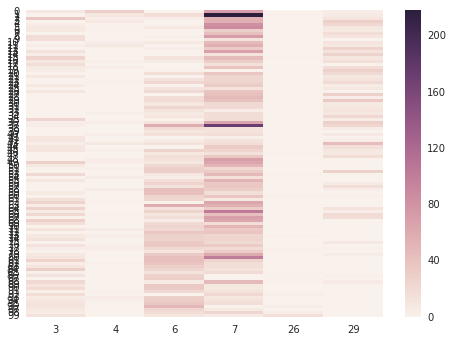

In [1016]:
import seaborn as sns
sns.heatmap(df_g[[3,4,6,7,26,29]],linewidths=0)

In [1067]:
from sklearn.cross_validation import train_test_split

#lrc_g = sklearn.ensemble.RandomForestRegressor(n_estimators=5000)
lrc_g = LinearRegression(fit_intercept=True, copy_X=True)
X_g = df_g[[3,4,6,7,26,29]].values
Y_g = df_g['Avg'].values

# split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_g, Y_g, test_size=0.33, random_state=42)

lrc_g.fit(X_train, Y_train)
y_predict = lrc_g.predict(X_test)
print lrc_g.score(X_test, Y_test)

0.675505791358


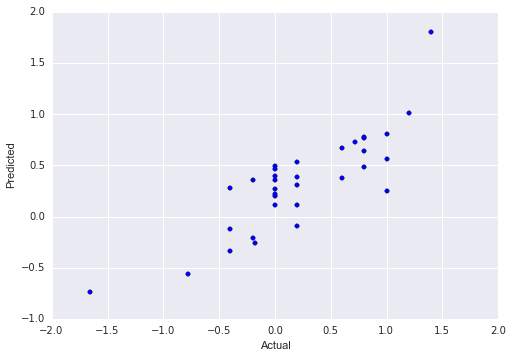

In [1068]:
plt.scatter(Y_test,y_predict);plt.xlabel('Actual');plt.ylabel('Predicted')

## Classify all blocked comments in corpus

In [1026]:
backer_comments_grouped_copy = backer_comments_grouped.copy(deep=True)

In [1027]:
backer_comments_grouped_copy.head(2)

,comment,date,project_id
0,as one of the biggest fans of the game tetris ...,2014-09-30,182943
1,got it! (20 nov) thanks. can't wait to experim...,2014-11-30,182943


In [1060]:
inferences = alphalda.inference(alphacorp)[0]
df_inference = pd.DataFrame(inferences)

In [1064]:
df_inference_total = pd.concat([df_inference, backer_comments_grouped_copy],axis=1)

In [1066]:
df_inference_total.shape

(17824, 33)

In [1072]:
### use linear regressor to map each month to a sentiment value
X_g = df_inference_total[[3,4,6,7,26,29]].values
predicted_sentiments = lrc_g.predict(X_g)
df_inference_total['sentiment'] = predicted_sentiments

In [1076]:
df_inference_total.sort('sentiment',ascending=True).head(2)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,comment,date,project_id,sentiment
842,0.033333,3.467283,0.033333,236.489611,159.677972,1.325942,75.884989,1061.751259,0.033333,15.596535,...,0.033333,169.046774,0.033333,373.237623,0.033333,1709.943387,"it was ""jamming"" a lot today, but i think i kn...",2013-11-30,101767263,-27.036652
7039,0.033333,61.890216,95.649958,68.566603,39.883118,1.164671,0.033333,1600.909016,0.033333,0.033333,...,5.516294,0.033333,12.588769,4.367049,5.206971,535.359798,"in france, still waiting for tracking number/s...",2013-10-31,842797490,-16.173275


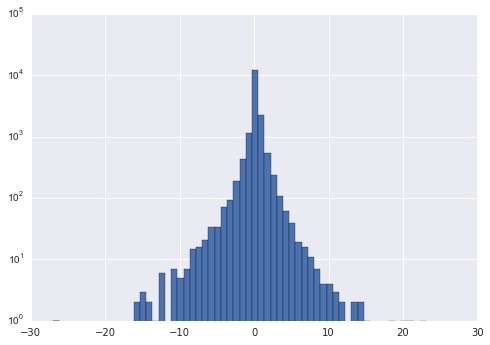

In [1096]:
plt.hist(predicted_sentiments,bins=60,log=True);

# Try to classify based on project features

In [1093]:
# load project features
all_data = pickle.load(open('data/all_data_tech.p','rb'))

In [1094]:
all_data_sentiments = pd.merge(all_data, df_inference_total[['comment','date','project_id','sentiment']],on='project_id',how='inner')

In [1119]:
# compute date from start of project
start_date = all_data_sentiments[['project_id','date']].groupby('project_id').agg(min).reset_index().rename(columns={'date':'start'})
end_date = all_data_sentiments[['project_id','date']].groupby('project_id').agg(max).reset_index().rename(columns={'date':'end'})

all_data_sentiments_date = pd.merge(all_data_sentiments, start_date, on='project_id',how='inner')
all_data_sentiments_date = pd.merge(all_data_sentiments_date, end_date, on='project_id', how='inner')

all_data_sentiments_date['duration'] = all_data_sentiments_date['end'] - all_data_sentiments_date['start']
all_data_sentiments_date['date_from_start'] = all_data_sentiments_date['date'] - all_data_sentiments_date['start']
all_data_sentiments_date['date_from_end'] = all_data_sentiments_date['end'] - all_data_sentiments_date['date']

In [1120]:
all_data_sentiments_date.head(2)

,project_id,log_backed,log_created,log_comments,log_backers,log_pledged,log_goal,technology,technology/3d printing,technology/apps,...,technology/wearables,technology/web,comment,date,sentiment,start,end,duration,date_from_start,date_from_end
0,1842798593,-1.252439,-0.548694,-0.927679,-0.061835,8.470521,-0.470500,0,0,0,...,0,1,this is such a necessary tool. we really must ...,2013-11-30,0.126987,2013-11-30,2013-11-30,0 days,0 days,0 days
1,717118235,1.733045,2.428856,1.378449,1.034797,9.995428,-0.944787,0,0,0,...,0,0,i am so stoked to see how your interactive app...,2015-03-31,0.347788,2015-03-31,2015-05-31,61 days,0 days,61 days


In [1112]:
pd.tslib.Timedelta(1,'M')

Timedelta('30 days 10:29:06')

In [1131]:
# Filter projects:
# remove comments 6 months before last comment and within 2 months of first comment
d_after_start = pd.tslib.Timedelta(2,'M')
d_before_end = pd.tslib.Timedelta(7,'M')

all_data_filtered = all_data_sentiments_date[all_data_sentiments_date['date_from_start'] > d_after_start]
all_data_filtered = all_data_filtered[all_data_filtered['date_from_end'] <= d_before_end]

In [1132]:
all_data_sentiments_date.shape

(17756, 31)

In [1133]:
all_data_filtered.shape

(4701, 31)

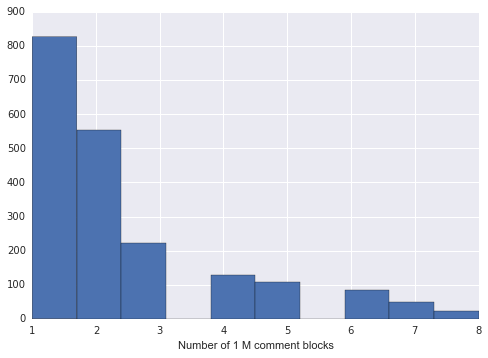

In [1134]:
plt.hist(all_data_filtered.groupby('project_id')['technology'].count().values);
plt.xlabel('Number of 1 M comment blocks')

In [1135]:
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

X_df = all_data_filtered.copy(deep=True);
X_df.drop(labels=['project_id','comment','date','sentiment','start','end','duration','date_from_start','date_from_end'],axis=1,inplace=True)
X = X_df.values

Y = all_data_filtered['sentiment'].values
# generate labels
#sent_average_threshold = -0.1
#Y_vals = (all_data['sent_avg'] < sent_average_threshold).values
#Y = map(lambda x:int(x), Y_vals)

# split into train/test sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [ ]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE(n_components = 2)
X_tsne = tsne.fit_transform(X)

In [ ]:
d = pd.DataFrame()
d['y'] = Y
d['X_red_0'] = X_tsne[:,0]
d['X_red_1'] = X_tsne[:,1]

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=-d['y'], alpha=0.5)
#d_worst = d[d['y'] <-0.1]
#plt.scatter(d_worst['X_red_0'], d_worst['X_red_1'],s=50,c='r')

# End recent work

## Regression

In [914]:
df_samp.iloc[18]['comment']

'Thank you!!! So awesome!'

In [877]:
# handle sampling - train on very positive and very negative
df_neg = df[df['Y_meas'] < -0.1]
df_pos = df[df['Y_meas'] >= 0.1]

df_neg_samp = df_neg.iloc[np.random.choice(range(df_neg.shape[0]), 100, replace=False)]
df_pos_samp = df_pos.iloc[np.random.choice(range(df_pos.shape[0]), 100, replace=False)]

df_train = pd.concat([df_neg_samp, df_pos_samp])
df_test = df.copy(deep=True)
df_test.drop(axis=0,labels=df_train.index.values,inplace=True)

# extract features, pre-process
X_train = df_train.drop('Y_meas', axis=1).values
X_test = df_test.drop('Y_meas',axis=1).values
Y_train = df_train['Y_meas']
Y_test = df_test['Y_meas']

from sklearn.linear_model import LinearRegression
lrc = LinearRegression(fit_intercept=True, copy_X=True)
from sklearn.linear_model import Lasso
#for alpha in [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2, 10, 100]:
#for alpha in [0.0001]:
    
import sklearn.ensemble# import RandomForestClassifier

# be sure to weight classes
#lrc = sklearn.ensemble.RandomForestRegressor(n_estimators=5000)

#    lrc = Lasso(alpha=alpha, normalize=True, max_iter=1e5)
lrc.fit(X_train, Y_train)
Y_predict = lrc.predict(df.drop('Y_meas',axis=1).values)

#print "alpha = %g, score = %g" % (alpha, lrc.score(X_train, Y_train))

In [893]:
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Y_meas
0,0.000002,0.000002,0.000002,0.000002,0.000002,0.071634,0.000002,0.000002,0.000002,0.000002,...,0.072729,0.000002,0.000002,0.000002,0.000002,0.782654,0.000002,0.000002,0.000002,2.0
1,0.000002,0.000002,0.000002,0.144728,0.000002,0.000002,0.000002,0.451943,0.000002,0.000002,...,0.000002,0.000002,0.152798,0.000002,0.000002,0.105588,0.000002,0.144897,0.000002,1.8


In [895]:
df_samp.head(2)

,3,4,6,7,26,29
0,0.000002,0.000002,0.000002,0.000002,0.782654,0.000002
1,0.144728,0.000002,0.000002,0.451943,0.105588,0.000002


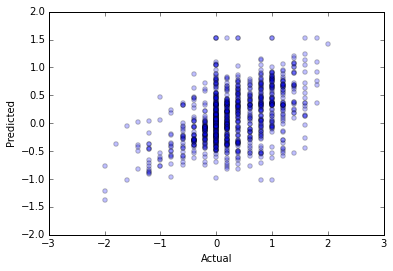

In [878]:
plt.scatter(df['Y_meas'], Y_predict,alpha=0.25);plt.xlabel('Actual');plt.ylabel('Predicted')

In [787]:
clf = sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

(900, 31)

## End more text processing

In [470]:
# inferred directly from word counts
# index is command-line index, NOT LDA-vis index
topics_used = [2, 10, 15, 23, 26, 0] # 0 holds everything else
topic_probabilities = {15:0.114, 23:0.106, 26:0.078, 10:0.061, 2:0.043}
norm = np.sum(list(topic_probabilities.values()))
topic_probabilities[0] = norm
sentiments = {15:-1, 23:-1, 26:1, 10:1, 2:1, 0:0}

In [471]:
sentiments

{0: 0, 2: 1, 10: 1, 15: -1, 23: -1, 26: 1}

In [457]:
topic_df.shape

(29613, 30)

In [440]:
dictionary_backer.num_nnz?

In [411]:
topic_df.loc[word_to_index['not']][0]  

1.0

In [341]:
lda_backer.log_perplexity?

In [362]:
lda_backer.show_topic(10)

[(0.032624813053641587, u'received'),
 (0.030338266220286243, u'not'),
 (0.019662311123613656, u'tracking'),
 (0.015154434787507096, u'number'),
 (0.012933797156675447, u'email'),
 (0.012598451273916081, u'mine'),
 (0.010726303255006134, u'today'),
 (0.010256895996630546, u'please'),
 (0.010078830382511691, u"'m"),
 (0.0095858981960620804, u"'s")]

In [525]:
dictionary_backer.doc2bow(['refund', 'refund'])

[(1094, 2)]

In [524]:
lda_backer.inference([dictionary_backer.doc2bow(['refund', 'refund'])])

(array([[ 0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
          0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
          0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
          0.03333333,  0.03333333,  2.03333333,  0.03333333,  0.03333333,
          0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
          0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333]]),
 None)

In [344]:
lda_backer.log_perplexity([dictionary_backer.doc2bow(['refund', 'refund'])])

-269027.53046116233

## Run LDA with more iterations

In [345]:
lda_backer_more_iterations, corpus_backer, dictionary_backer, id2word_backer = run_lda(backer_processed, n_topics)

In [347]:
pyLDAvis.gensim.prepare(lda_backer_more_iterations, corpus_backer, dictionary_backer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      10.129880        1       1 -0.059044  0.015322
13      9.538416        1       2 -0.040224 -0.153822
4       8.225637        1       3 -0.046476 -0.035915
8       8.118821        1       4 -0.054328 -0.109029
10      7.383463        1       5 -0.015938 -0.161573
20      7.050383        1       6 -0.033017 -0.148733
18      6.994051        1       7 -0.060778 -0.070210
21      6.359427        1       8 -0.073618  0.029689
26      4.446122        1       9 -0.089532  0.053849
15      3.390935        1      10 -0.078659  0.090539
19      3.226945        1      11 -0.069416  0.030582
2       3.006466        1      12 -0.071483  0.077049
7       2.569656        1      13 -0.051713 -0.153829
23      2.532885        1      14 -0.080928  0.014432
24      1.993562        1      15 -0.040169 -0.021838
1       1.987182        1      16 -0.077885  0.093454
0       1.986096        1      17 -0.000204 -0.026396
22      1.776833        1      18 -0.073643  0.112987
17      1.412292        1      19 -0.033406 -0.055390
27      1.109825        1      20 -0.061336  0.057965
6       1.101248        1      21  0.040412 -0.125097
25      0.885050        1      22  0.002773  0.040703
3       0.776257        1      23  0.002804  0.125086
16      0.750225        1      24  0.005623  0.252226
28      0.741780        1      25  0.172148 -0.084685
29      0.698926        1      26 -0.003122  0.009062
12      0.639180        1      27  0.024742  0.019699
14      0.489942        1      28  0.053662  0.087693
9       0.401730        1      29  0.379509 -0.068430
11      0.276784        1      30  0.433249  0.104610, topic_info=      Category           Freq         Term   Total  loglift  logprob
101    Default   27881.000000           --   27881  30.0000  30.0000
42     Default  111724.000000            @  111724  29.0000  29.0000
451    Default   18184.000000          app   18184  28.0000  28.0000
1094   Default   12372.000000       refund   12372  27.0000  27.0000
173    Default   12743.000000       backed   12743  26.0000  26.0000
28     Default   41907.000000      project   41907  25.0000  25.0000
24     Default  121117.000000          not  121117  24.0000  24.0000
835    Default   13478.000000      printer   13478  23.0000  23.0000
403    Default   22932.000000     received   22932  22.0000  22.0000
747    Default   29322.000000      product   29322  21.0000  21.0000
343    Default   28590.000000     shipping   28590  20.0000  20.0000
306    Default   26895.000000       please   26895  19.0000  19.0000
23     Default   15787.000000        money   15787  18.0000  18.0000
31     Default   39442.000000       thanks   39442  17.0000  17.0000
270    Default   33019.000000  kickstarter   33019  16.0000  16.0000
410    Default   29764.000000          use   29764  15.0000  15.0000
99     Default   94687.000000           's   94687  14.0000  14.0000
307    Default   21799.000000       pledge   21799  13.0000  13.0000
786    Default    8988.000000          usb    8988  12.0000  12.0000
91     Default   34264.000000       update   34264  11.0000  11.0000
14573  Default    7063.000000         pono    7063  10.0000  10.0000
578    Default   10997.000000      battery   10997   9.0000   9.0000
5707   Default    4324.000000       shirts    4324   8.0000   8.0000
26     Default   28424.000000       people   28424   7.0000   7.0000
874    Default    4904.000000     facebook    4904   6.0000   6.0000
3008   Default    8043.000000      android    8043   5.0000   5.0000
397    Default   14734.000000         mine   14734   4.0000   4.0000
521    Default   13441.000000       device   13441   3.0000   3.0000
3470   Default   11086.000000        phone   11086   2.0000   2.0000
993    Default   15946.000000      creator   15946   1.0000   1.0000
...        ...            ...          ...     ...      ...      ...
23256  Topic30       

## OTHER

In [215]:
# find comments with greatest probability of a given topic
backer_processed_lda = backer_processed.copy(deep=True)

backer_processed.head(2)

,comment,date,project_id,tokenized,stopped
0,as one of the biggest fans of the game tetris ...,2014-09-30,182943,"[as, one, of, the, biggest, fans, of, the, gam...","[people, money, hard, thanks, mentioned, bit, ..."
1,got it! (20 nov) thanks. can't wait to experim...,2014-12-31,182943,"[got, it, !, (, 20, nov, ), thanks, ., ca, n't...","[20, kamiel, experiment, thanks, nov, wait]"


In [219]:
from collections import defaultdict

In [223]:
x = lda_backer[dictionary_backer.doc2bow(backer_processed.iloc[200]['stopped'])]
d = defaultdict(dict)
for t in range(30):
    d[t] = 0
for t in x:
    d[t[0]] = t[1]

In [227]:
df = pd.DataFrame(d,index=[0])

In [228]:
df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,0,0,0,0,0,0,0,0.542976,0.41258,...,0,0,0,0,0,0,0,0,0,0


In [250]:
pyLDAvis.gensim.prepare(lda_creator, corpus_creator, dictionary_creator)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
12     14.093694        1       1  0.123954 -0.144533
27     11.601042        1       2  0.144848 -0.065189
26      9.121399        1       3  0.141154  0.012964
1       8.891952        1       4  0.139579  0.029897
4       8.308386        1       5  0.134755 -0.064005
14      8.180766        1       6  0.154570 -0.103241
25      4.241549        1       7  0.135672  0.117420
19      3.981318        1       8  0.147091 -0.003111
23      3.583600        1       9  0.112316  0.139950
16      3.451422        1      10  0.106043 -0.128959
2       3.190911        1      11  0.131679  0.124844
9       3.102632        1      12  0.115054  0.127854
6       2.455423        1      13  0.076165  0.158783
28      1.969528        1      14  0.063607  0.034157
17      1.895869        1      15  0.082721  0.082732
3       1.867684        1      16  0.069906 -0.014286
29      1.813557        1      17  0.086274 -0.048062
21      1.575188        1      18  0.029112 -0.197710
22      1.318721        1      19 -0.083034 -0.281450
7       1.310552        1      20  0.012332 -0.129567
0       0.837136        1      21 -0.011651  0.013406
24      0.676828        1      22 -0.120440  0.016689
8       0.675937        1      23 -0.075133  0.216502
10      0.591670        1      24 -0.067528  0.100231
11      0.433676        1      25 -0.162527 -0.061375
5       0.192859        1      26 -0.294252  0.036013
20      0.179202        1      27 -0.291003  0.011177
15      0.174701        1      28 -0.294797  0.022568
13      0.173873        1      29 -0.294843 -0.007954
18      0.108925        1      30 -0.311621  0.004254, topic_info=      Category          Freq         Term  Total  loglift  logprob
41     Default  60937.000000            @  60937  30.0000  30.0000
63     Default  10423.000000           hi  10423  29.0000  29.0000
251    Default  11405.000000        thank  11405  28.0000  28.0000
33     Default  21840.000000       thanks  21840  27.0000  27.0000
374    Default   5170.000000           --   5170  26.0000  26.0000
247    Default  11943.000000      support  11943  25.0000  25.0000
790    Default   5676.000000         team   5676  24.0000  24.0000
380    Default   3896.000000          hey   3896  23.0000  23.0000
90     Default  10817.000000       update  10817  22.0000  22.0000
2149   Default   5386.000000          app   5386  21.0000  21.0000
1333   Default   3905.000000      battery   3905  20.0000  20.0000
78     Default   5253.000000      project   5253  19.0000  19.0000
307    Default   9800.000000       please   9800  18.0000  18.0000
180    Default   8160.000000  kickstarter   8160  17.0000  17.0000
733    Default   3608.000000        power   3608  16.0000  16.0000
174    Default   4493.000000         http   4493  15.0000  15.0000
391    Default   9185.000000      backers   9185  14.0000  14.0000
199    Default  25457.000000          not  25457  13.0000  13.0000
94     Default  19611.000000           's  19611  12.0000  12.0000
2626   Default   2175.000000      regards   2175  11.0000  11.0000
237    Default   8539.000000     shipping   8539  10.0000  10.0000
17438  Default   1725.000000         zano   1725   9.0000   9.0000
288    Default   4759.000000        email   4759   8.0000   8.0000
308    Default   4271.000000       pledge   4271   7.0000   7.0000
549    Default   2933.000000    regarding   2933   6.0000   6.0000
735    Default   1685.000000      printer   1685   5.0000   5.0000
35     Default   8330.000000          use   8330   4.0000   4.0000
1069   Default   1846.000000        light   1846   3.0000   3.0000
440    Default   2989.000000          usb   2989   2.0000   2.0000
1503   Default   1232.000000          box   1232   1.0000   1.0000
...        ...           ...          ...    ...      ...      ...
23297  Topic30     28.809525         auch     30   6.5683  -4.5051
23322  Topic30    

In [ ]:
def get_toppic_weights(row, lda):
    